In [61]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import tensorflow as tf
import torchvision
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import sklearn
import seaborn as sns
import cv2
import skimage.exposure
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
import PIL
from sklearn import metrics
import os
from tqdm.notebook import tqdm, trange

In [2]:
csv_data = pd.read_csv('./blocks-labels.csv')
print(csv_data.shape)
print(csv_data[:3])
print('Number of stable:',np.count_nonzero(csv_data.stable==1))
print('Number of unstable:',np.count_nonzero(csv_data.stable==0))

# get the shuffle csv
shuffled_csv = sklearn.utils.shuffle(csv_data)

(51276, 2)
   id  stable
0   1       1
1   2       1
2   3       1
Number of stable: 27034
Number of unstable: 24242


In [3]:
print(shuffled_csv[:3])
X = shuffled_csv.id
Y = shuffled_csv.stable
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.3)

          id  stable
8001    8002       0
34398  34399       1
27005  27006       1


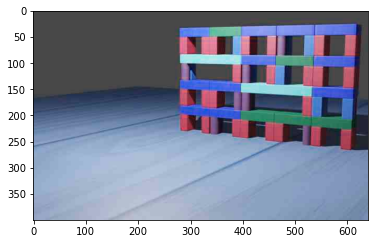

In [29]:
# load image
img = cv2.imread('./data/20000.jpg')
# fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img)

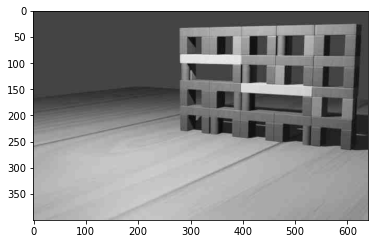

In [30]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

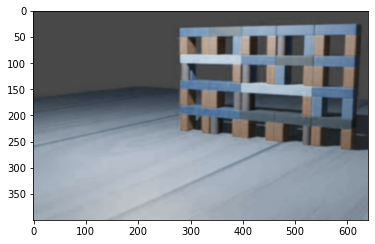

In [39]:
blur = gaussian_filter(img, sigma=1.2)
plt.imshow(blur)

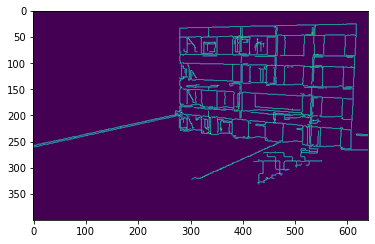

In [37]:
v = np.median(img)
# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - 1.5) * v))
upper = int(min(255, (1.0 + 1.5) * v))
edged = cv2.Canny(img, lower, upper)
plt.imshow(edged)

In [45]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = RezNetTransform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        filename = str(self.df.id[index])+'.jpg'
        label = self.df.stable[index]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        sample = {'image': image, 'stable': label}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

train_dataset1 = CustomDataset("blocks-labels.csv", './data'  )


In [42]:
RezNetTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [63]:
train_size = int(0.8 * full_dataset)
test_size = 51276 - train_size
traindataset1, testdataset1 = torch.utils.data.random_split(train_dataset1, [train_size, test_size])
print(len(traindataset1))
print(len(testdataset1))

NameError: name 'full_dataset' is not defined